# 0. Installation of the environment

In order to use the environment, you have to install the package gym-foo with **pip install -e gym-foo** were the directory is located (at least on linux).

In [1]:
import gym
import numpy
import matplotlib.pyplot as plt
env = gym.make('gym_foo:foo-v0', cr = 7, pr = 10, np = 2, ng = 10, alphas = [1,1]) # you can pass the arguments of the __init__ method here

# 1. Principe du jeu

The game has a finite number of rounds.

In each round, each player can choose to **cooperate** or **play selfishly**.
All players make their choice simultaneously. Thus, no player knows what the others choose during the current round.

At the beginning of the round, the collective fund is empty.
If a player **cooperates**, he increases the collective pool by C, but his **personal bonus** is void.
If he **does not**, the collective fund does not increase, but his **personal bonus** is worth P.
C and P are fixed at the beginning of the game and are known to all.

The collective prize pool then corresponds to C multiplied by the number of cooperating players.

At the end of the round, **each** player receives an amount equal to the total amount of the collective prize pool, plus their personal bonus, regardless of their choice. 

$R_i = C\left(\sum_{j=1}^n \mathbb{1}_{a_j=0} \right) + P\mathbb{1}_{a_i=1} = C \left(1+\sum_{j\neq i}^n \mathbb{1}_{a_j=0} \right) + \left(P- C\right)\mathbb{1}_{a_i=1}$
where $R_i$ is the $i$-th player's win in the last round (so not the accumulated winnings), $a_i$ is the action of the $i$-th player in the considered turn, with $a_i=1$ if he prefers and $a_i=0$ otherwise, and $P > C$.


If C is too low (nC <= P where n is the number of players), then the players have no interest in cooperating.
The game is only interesting if nC > P.

The interest of the game lies in the strategies adopted by the players. The best situation for a player is the one where he is privileged and all the others cooperate. But in this case, he loses the confidence of the other players who can make him pay for it in the following turns by not cooperating any more. 

If there are only a few players in the game, one would expect to see different behaviour, since taking revenge on one player will reduce the winnings of all of them.

Here is an example of a 2-player game in three rounds, with $P = $10 and $C = $7: 
```text
 iter  | p1 | p2
    1  |  0 |  0
rewards| 14 | 14 
    2  |  1 |  0
rewards| 17 |  7
    3  |  1 |  1
rewards| 10 | 10
-----------------
total  | 41 | 31
```

At the first all, both players have cooperated, so the collective prize pool is 2*7 = 14 and neither receives a bonus.
In the second round, only p2 cooperates. The collective jackpot is worth 7 and p1 receives a bonus of 10.
In the third round, no player cooperates. The community pool is void and both players receive a bonus of 10.

# 2. Basic example 

In [2]:
for i_episode in range(1):
    observation = env.reset()
    for t in range(10):
#         env.render()
#         print(observation)
        action = numpy.random.randint(0,2,env.num_of_players)
        observation, reward, done, info = env.step(action)

        if done:
            env.close()
            break

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 1  
     2| 1  | 0  
     3| 1  | 1  
     4| 0  | 1  
     5| 1  | 0  
     6| 0  | 1  
     7| 0  | 0  
     8| 1  | 0  
     9| 0  | 1  
    10| 1  | 0  
scores|120 |120 
 util |120 |120 

p1 has won !


# 3. Test with Q-Learning and tables
We initialize with the reward of a 1-turn game according to the number of cooperating agent and the action the agent has chosen.

We implement a function to enhance the lisibility of the result tables.

In [3]:
def interpretation(table):
    num_of_players = table.shape[1]
    print("num of cooperating players | Q-value if cooperating | Q-value if not")
    for i,line in enumerate(table):
        print("{0:^26} | {1:^22} | {2:^14}".format(i,*line))

## 3.1 $\epsilon$-greedy selection, $\epsilon$ decreasing

In [4]:
tables = [numpy.zeros((env.num_of_players,2)) for player in env.player]
alpha = .9
gamma = .85
epsilon = 0.5
numpy.random.seed(42)
nb_iter = 100000
scores = numpy.zeros((env.num_of_players,nb_iter))

for i_episode in range(nb_iter):
    s_t1 = env.reset()
    
    for t in range(10):
#         env.render()
        if t == 0:
            s_t1 = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.
            
        a_t1 = numpy.zeros(env.num_of_players, dtype = "int")
        for i,player in enumerate(env.player):
            # The only relevant information is the number of agents who chose to cooperate.
            # We simplify the state with the number of cooperating agents.
            # We will update a table in order to find the best action according to the number of cooperating players
            
            coop = env.num_of_players - 1 - (sum(s_t1) - s_t1[i])
            best_action = numpy.argmax(tables[i][coop])
            if 1-epsilon/(i_episode + 1) > numpy.random.uniform():  
                a_t1[i] = best_action
            else:
                a_t1[i] = 1 - best_action

        s_t2, r_t1, done, info = env.step(a_t1)
        for i,player in enumerate(env.player):
            tab = tables[i]
            coop_t1, coop_t2 = env.num_of_players - 1 - (sum(s_t1) - s_t1[i]), env.num_of_players - 1 -(sum(s_t2) - s_t2[i])

            tab[coop_t1][a_t1[i]] += alpha * (r_t1[i] + gamma * max(tab[coop_t2]) - tab[coop_t1][a_t1[i]])
        
        s_t1 = s_t2
            
        if done:
            current_scores = [player.balance for player in env.player]
            for i,player in enumerate(env.player):
                scores[i,i_episode] = player.utility(current_scores[i], current_scores)
            break

In [5]:
for player, table in zip(env.player, tables):
    print(player.name)
    interpretation(table)

p1
num of cooperating players | Q-value if cooperating | Q-value if not
            0              |   63.66666666666671    | 66.66666666666671
            1              |   63.675044854998475   | 66.66666666666671
p2
num of cooperating players | Q-value if cooperating | Q-value if not
            0              |   63.66666666666671    | 66.66666666666671
            1              |   63.66666671756393    | 66.66666666666671


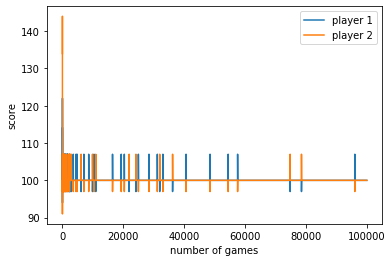

In [6]:
plt.plot(list(range(1,nb_iter + 1)), scores[0,:], label = "player 1")
plt.plot(list(range(1,nb_iter + 1)), scores[1,:], label = "player 2")
plt.xlabel("number of games")
plt.ylabel("score")
plt.legend()
plt.show()

In [7]:
env.reset()

for t in range(10):
#     env.render()
    if t == 0:
        state = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.

    action = numpy.zeros(env.num_of_players, dtype = "int")
    for i,player in enumerate(env.player):
        coop = env.num_of_players - 1 - (sum(state) - state[i]) # Number of players who have cooperated among the other agents
        best_action = numpy.argmax(tables[i][coop])  
        action[i] = best_action
    
    state, rewards, done, info = env.step(action)
    
    if done:
        env.close()

End of the 10 turns.
 iter | p1 | p2 
     1| 1  | 1  
     2| 1  | 1  
     3| 1  | 1  
     4| 1  | 1  
     5| 1  | 1  
     6| 1  | 1  
     7| 1  | 1  
     8| 1  | 1  
     9| 1  | 1  
    10| 1  | 1  
scores|100 |100 
 util |100 |100 

p1 has won !


Both players choose the same strategy, which is never cooperating.

But the scores are not very high. 
We recall that if both were cooperating at each turn, they would both get 140.

## 3.2 Softmax selection 

In [22]:
tables = [numpy.zeros((env.num_of_players,2)) for player in env.player]
for table in tables:
    for i in range(table.shape[1]):
        table[i]=[0,0]

alpha = .9
gamma = .85
tau = 100
numpy.random.seed(42)
nb_iter = 100000
scores = numpy.zeros((env.num_of_players,nb_iter))

for i_episode in range(nb_iter):
    s_t1 = env.reset()
    
    for t in range(10):
        if t == 0:
            s_t1 = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.
            
        a_t1 = numpy.zeros(env.num_of_players, dtype = "int")
        for i,player in enumerate(env.player):
            # The only relevant information is the number of agents who chose to cooperate.
            # We simplify the state with the number of cooperating agents.
            # We will update a table in order to find the best action according to the number of cooperating players
            
            coop = env.num_of_players - 1 - (sum(s_t1) - s_t1[i])
            p0,p1 = numpy.exp(tables[i][coop,0]/tau),numpy.exp(tables[i][coop,1]/tau)
            if p0/(p0+p1) > numpy.random.uniform():  
                a_t1[i] = 0
            else:
                a_t1[i] = 1

        s_t2, r_t1, done, info = env.step(a_t1)
        for i,player in enumerate(env.player):
            tab = tables[i]
            coop_t1, coop_t2 = env.num_of_players - 1 - (sum(s_t1) - s_t1[i]), env.num_of_players - 1 -(sum(s_t2) - s_t2[i])

            tab[coop_t1][a_t1[i]] += alpha * (r_t1[i] + gamma * max(tab[coop_t2]) - tab[coop_t1][a_t1[i]])
        s_t1 = s_t2
            
        if done:
            current_scores = [player.balance for player in env.player]
            for i,player in enumerate(env.player):
                scores[i,i_episode] = player.utility(current_scores[i], current_scores)
            break

In [23]:
for player, table in zip(env.player, tables):
    print(player.name)
    interpretation(table)

p1
num of cooperating players | Q-value if cooperating | Q-value if not
            0              |    84.628986330265     | 90.31851037633925
            1              |   87.28870140973734    | 87.27697335905442
p2
num of cooperating players | Q-value if cooperating | Q-value if not
            0              |   94.33095143369592    | 97.24496068406769
            1              |   93.46828607745053    | 94.1768786283681


p1 cooperates if the other has cooperated, and choose to play selfish if the other has not cooperated.
p2 always plays selfish.

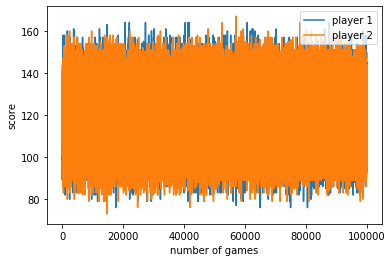

In [24]:
plt.plot(list(range(1,nb_iter + 1)), scores[0,:], label = "player 1")
plt.plot(list(range(1,nb_iter + 1)), scores[1,:], label = "player 2")
plt.xlabel("number of games")
plt.ylabel("score")
plt.legend()
plt.show()

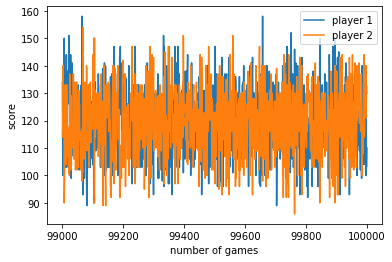

In [32]:
plt.plot(list(range(99001,nb_iter + 1)), scores[0,99000:], label = "player 1")
plt.plot(list(range(99001,nb_iter + 1)), scores[1,99000:], label = "player 2")
plt.xlabel("number of games")
plt.ylabel("score")
plt.legend()
plt.show()

We see that the scores do not converge. It is because both Q-values of an agent are very close, so both actions are almost equiprobable.

In [33]:
env.reset()

for t in range(10):
#     env.render()
    if t == 0:
        state = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.

    action = numpy.zeros(env.num_of_players, dtype = "int")
    for i,player in enumerate(env.player):
        coop = env.num_of_players - 1 - (sum(state) - state[i])
        best_action = numpy.argmax(tables[i][coop])  
        action[i] = best_action
    
    state, rewards, done, info = env.step(action)
    
    if done:
        env.close()

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 1  
     2| 1  | 1  
     3| 1  | 1  
     4| 1  | 1  
     5| 1  | 1  
     6| 1  | 1  
     7| 1  | 1  
     8| 1  | 1  
     9| 1  | 1  
    10| 1  | 1  
scores| 97 |107 
 util | 97 |107 

p2 has won !


Here, p2 seems rather dumb. So p1 has the best strategy, whereas p2 has the worst one.

## 3.3 What if p2 has a constant policy ?

A policy giving pretty good results it the following one :
    the agent cooperates until the other one does not. Then, it never cooperates again.

### 3.3.1 $\epsilon$-greedy selection

In [34]:
table = numpy.zeros((env.num_of_players,2))
alpha = .9
gamma = .85
epsilon = 0.5
numpy.random.seed(42)
nb_iter = 10000
scores = numpy.zeros((env.num_of_players,nb_iter))

for i_episode in range(nb_iter):
    s_t1 = env.reset()
    betrayal = False
    
    for t in range(10):

        if t == 0:
            s_t1 = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.
        
        a_t1 = numpy.zeros(env.num_of_players, dtype = "int")
        
        # For the learning agent
        coop = env.num_of_players - 1 - (sum(s_t1) - s_t1[0])
        best_action = numpy.argmax(table[coop])
        if 1-epsilon/(i_episode + 1) > numpy.random.uniform():  
            a_t1[0] = best_action
        else:
            a_t1[0] = 1 - best_action
            
        # For the agent with constant policy
        a_t1[1] = 1*betrayal
        if a_t1[0] == 1:
            betrayal = True

        s_t2, r_t1, done, info = env.step(a_t1)
        
        coop_t1, coop_t2 = env.num_of_players - 1 - (sum(s_t1) - s_t1[0]), env.num_of_players - 1 -(sum(s_t2) - s_t2[0])
        table[coop_t1][a_t1[0]] += alpha * (r_t1[0] + gamma * max(table[coop_t2]) - table[coop_t1][a_t1[0]])
        
        s_t1 = s_t2
            
        if done:
            current_scores = [player.balance for player in env.player]
            for i,player in enumerate(env.player):
                scores[i,i_episode] = player.utility(current_scores[i], current_scores)
            break

In [35]:
print("p1")
interpretation(table)

p1
num of cooperating players | Q-value if cooperating | Q-value if not
            0              |   63.666666666663616   | 66.6666666666666
            1              |   93.33333333333329    | 69.3662954545454


We see that against an agent having a constant policy, our agent do learn a good strategy.
Yet it is not the best one : it would be better to not cooperate in the last turn, but with that table our agent has no idea which turn it is. 

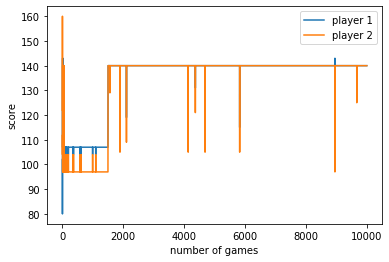

In [37]:
plt.plot(list(range(1,nb_iter + 1)), scores[0,:], label = "player 1")
plt.plot(list(range(1,nb_iter + 1)), scores[1,:], label = "player 2")
plt.xlabel("number of games")
plt.ylabel("score")
plt.legend()
plt.show()

In [16]:
env.reset()
betrayal = False

for t in range(10):
    
    if t == 0:
        state = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.

    action = numpy.zeros(env.num_of_players, dtype = "int")
    coop = env.num_of_players - 1 - (sum(state) - state[0])
    best_action = numpy.argmax(table[coop])  
    action[0] = best_action
    action[1] = 1*betrayal
    if action[0] == 1:
        betrayal = True
    
    state, rewards, done, info = env.step(action)
    
    if done:
        env.close()

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 0  
     4| 0  | 0  
     5| 0  | 0  
     6| 0  | 0  
     7| 0  | 0  
     8| 0  | 0  
     9| 0  | 0  
    10| 0  | 0  
scores|140 |140 
 util |140 |140 

p1 has won !


### 3.3.2 Softmax-selection

In [38]:
table = numpy.zeros((env.num_of_players,2))
alpha = .9
gamma = .85
tau = 5
numpy.random.seed(42)
nb_iter = 10000
scores = numpy.zeros((env.num_of_players,nb_iter))

for i_episode in range(nb_iter):
    s_t1 = env.reset()
    betrayal = False
    
    for t in range(10):
#         env.render()
        if t == 0:
            s_t1 = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.
            
        a_t1 = numpy.zeros(env.num_of_players, dtype = "int")
        
        # Learning agent
        coop = env.num_of_players - 1 - (sum(s_t1) - s_t1[0])
        p0,p1 = numpy.exp(table[coop,0]/tau),numpy.exp(table[coop,1]/tau)
        if p0/(p0+p1) > numpy.random.uniform():  
            a_t1[0] = 0
        else:
            a_t1[0] = 1
            
        # Other one
        a_t1[1] = 1*betrayal
        
        if a_t1[0] == 1:
            betrayal = True
        
        s_t2, r_t1, done, info = env.step(a_t1)
        coop_t1, coop_t2 = env.num_of_players - 1 - (sum(s_t1) - s_t1[0]), env.num_of_players - 1 -(sum(s_t2) - s_t2[0])

        table[coop_t1][a_t1[0]] += alpha * (r_t1[0] + gamma * max(table[coop_t2]) - table[coop_t1][a_t1[0]])
        s_t1 = s_t2
            
        if done:
            current_scores = [player.balance for player in env.player]
            for i,player in enumerate(env.player):
                scores[i,i_episode] = player.utility(current_scores[i], current_scores)
            break

In [39]:
print("p1")
interpretation(table)

p1
num of cooperating players | Q-value if cooperating | Q-value if not
            0              |          0.0           | 66.6666666666666
            1              |   93.33333333333329    | 69.36362932787895


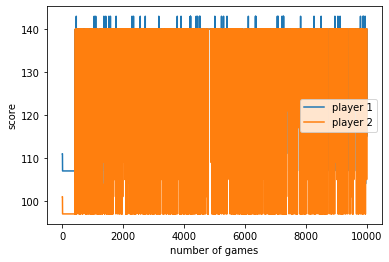

In [40]:
plt.plot(list(range(1,nb_iter + 1)), scores[0,:], label = "player 1")
plt.plot(list(range(1,nb_iter + 1)), scores[1,:], label = "player 2")
plt.xlabel("number of games")
plt.ylabel("score")
plt.legend()
plt.show()

Softmax-selection requires to fine-tune $\tau$. If $\tau$ is small enough, our agent learn the best possible behaviour.

In [41]:
env.reset()
betrayal = False

for t in range(10):
    
    if t == 0:
        state = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.

    action = numpy.zeros(env.num_of_players, dtype = "int")
    coop = env.num_of_players - 1 - (sum(state) - state[0])
    best_action = numpy.argmax(table[coop])  
    action[0] = best_action
    action[1] = 1*betrayal
    if action[0] == 1:
        betrayal = True
    
    state, rewards, done, info = env.step(action)
    
    if done:
        env.close()

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 0  
     4| 0  | 0  
     5| 0  | 0  
     6| 0  | 0  
     7| 0  | 0  
     8| 0  | 0  
     9| 0  | 0  
    10| 0  | 0  
scores|140 |140 
 util |140 |140 

p1 has won !


## 3.4 With a bigger table, covering all possibilities (for a game with only 2 players).

In [21]:
observation = numpy.zeros((env.num_of_games,env.num_of_players))
p = 2*env.num_of_players
table = numpy.zeros(2*(p**(env.num_of_games)-1)//(p-1),dtype="int")
alpha = .9
gamma = .85
epsilon = 0.2
numpy.random.seed(42)
nb_iter = 100000
scores = numpy.zeros((env.num_of_players,nb_iter))

action = numpy.zeros(env.num_of_players, dtype = "int")

for i_episode in range(nb_iter):
    state = env.reset()
    betrayal = False
    
    for t in range(env.num_of_games):
        
        # For the learning agent
        case = int(2*(4**t-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t].ravel())])) # First case corresponding to the situation
        # The second one if just the following one
        best_action = numpy.argmax(table[case:case+2])
        if 1-epsilon > numpy.random.uniform():  
            action[0] = best_action
            case += best_action
        else:
            action[0] = 1 - best_action
            case += 1-best_action
            
        # For the agent with constant policy
        action[1] = 1*betrayal
        if action[0] == 1:
            betrayal = True

        state, reward, done, info = env.step(action)
        observation[t,:] = state.copy()
        
        case2 = int(2*(4**(t+1)-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t+1].ravel())]))
        if t < env.num_of_games-1:
            table[case] += alpha * (reward[0] + gamma * max(table[case2:case2+2]) - table[case])
        else:
            table[case] += alpha * reward[0]
            
        if done:
            current_scores = [player.balance for player in env.player]
            for i,player in enumerate(env.player):
                scores[i,i_episode] = player.utility(current_scores[i], current_scores)
            break

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/weber/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-e14cb17dcedf>", line 46, in <module>
    scores[i,i_episode] = player.utility(current_scores[i], current_scores)
  File "/home/weber/Bureau/Projet/INF581/gym-foo/gym_foo/envs/foo_env.py", line 57, in utility
    return score**self.alpha * bonus**(1-self.alpha)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/weber/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/weber/anaconda3/lib/python3

KeyboardInterrupt: 

In [ ]:
observation = numpy.zeros((env.num_of_games,env.num_of_players))
p = 2*env.num_of_players
numpy.random.seed(42)

action = numpy.zeros(env.num_of_players, dtype = "int")

state = env.reset()
betrayal = False

for t in range(env.num_of_games):

    # For the learning agent
    case = int(2*(4**t-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t].ravel())]))
    action[0] = numpy.argmax(table[case:case+2])
    case += action[0]

    # For the agent with constant policy
    action[1] = 1*betrayal
    if action[0] == 1:
        betrayal = True

    state, reward, done, info = env.step(action)
    observation[t,:] = state.copy()

    if done:
        env.render()

If we want to see what happens whith wo learning agents :

In [ ]:
observation_p1 = numpy.zeros((env.num_of_games,env.num_of_players))
observation_p2 = numpy.zeros((env.num_of_games,env.num_of_players))
p = 2*env.num_of_players
table_p1 = numpy.zeros(2*(p**(env.num_of_games)-1)//(p-1),dtype="int")
table_p2 = numpy.zeros(2*(p**(env.num_of_games)-1)//(p-1),dtype="int")
alpha = .5
gamma = .85
epsilon = 0.2
numpy.random.seed(42)
nb_iter = 1000000
scores = numpy.zeros((env.num_of_players,nb_iter))

action = numpy.zeros(env.num_of_players, dtype = "int")

for i_episode in range(nb_iter):
    state = env.reset()
    if i_episode % (nb_iter//100) == 0:
        print(i_episode//(nb_iter//100))
    
    for t in range(env.num_of_games):
        
        # For p1
        case1_p1 = int(2*(4**t-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t].ravel())]))
        best_action_p1 = numpy.argmax(table[case1_p1:case1_p1+2])
        if 1-epsilon > numpy.random.uniform():  
            action[0] = best_action_p1
            case1_p1 += best_action_p1
        else:
            action[0] = 1 - best_action_p1
            case1_p1 += 1-best_action_p1
            
        # For the agent with constant policy
        case1_p2 = int(2*(4**t-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t].ravel())]))
        best_action_p2 = numpy.argmax(table[case1_p2:case1_p2+2])
        if 1-epsilon > numpy.random.uniform():  
            action[1] = best_action_p2
            case1_p2 += best_action_p2
        else:
            action[1] = 1 - best_action_p2
            case1_p2 += 1-best_action_p2

        state, reward, done, info = env.step(action)
        observation[t,:] = state.copy()
        
        case2_p1 = int(2*(4**(t+1)-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t+1].ravel())]))
        if t < env.num_of_games-1:
            table_p1[case1_p1] = numpy.log(numpy.exp(table_p1[case1_p1]) + alpha * (reward[0] + gamma * max(table_p1[case2_p1:case2_p1+2]) - table_p1[case1_p1]))
        else:
            table_p1[case1_p1] = numpy.log(reward[0])
            
        case2_p2 = int(2*(4**(t+1)-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t+1].ravel())]))
        if t < env.num_of_games-1:
            table_p2[case1_p2] = numpy.log(numpy.exp(table_p2[case1_p2]) + alpha * (reward[1] + gamma * max(table_p2[case2_p2:case2_p2+2]) - table_p1[case1_p2]))
        else:
            table_p2[case1_p2] = numpy.log(reward[1])
            
        if done:
            current_scores = [player.balance for player in env.player]
            for i,player in enumerate(env.player):
                scores[i,i_episode] = player.utility(current_scores[i], current_scores)
            break

In [ ]:
observation = numpy.zeros((env.num_of_games,env.num_of_players))
p = 2*env.num_of_players
numpy.random.seed(42)

action = numpy.zeros(env.num_of_players, dtype = "int")

state = env.reset()

for t in range(env.num_of_games):

    # For the learning agent
    case_p1 = int(2*(4**t-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t].ravel())]))
    action[0] = numpy.argmax(table_p1[case_p1:case_p1+2])
    case_p1 += action[0]

    # For the agent with constant policy
    case_p2 = int(2*(4**t-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t].ravel())]))
    action[1] = numpy.argmax(table_p2[case_p2:case_p2+2])
    case_p2 += action[1]

    state, reward, done, info = env.step(action)
    observation[t,:] = state.copy()

    if done:
        env.render()

# 4. Building an agent with memory : policy-based methods

We could create a table with the iteration to learn a better behaviour against the constant agent. <br>
But let's say we want an agat able to imitate its behaviour : cooperating until the other one betrays, then never again.

With only the iteration added, our agent will not be able to learn it.
We could create a table with every possible policy for the other agent, but its size would be huge. And it would grow exponentially with the number of agents involved.

Let's rather focus directly on the policy. We are going to try to find a good and simple parametrization for the policy.


## 4.1 Parametrization

$\pi_i(t) = \mathbb{1}\{\theta_0+\sum_{j=1}^{t-1}\theta_{j,1} N_j + \theta_{j,2}\} \geq 0$

We have the previous agent with $\theta_0 = -1$, $\forall 1 \leq j \leq 9, \theta_{j,1} = 1$ and $\forall 1 \leq j \leq 9, \theta_{j,2} = 0$ , ie $$\theta = \begin{pmatrix} -1 & 0 \\ 1 & 0 \\ \vdots & \vdots\\ 1 & 0 \end{pmatrix}$$

And we have the agent we want with $$\theta = \begin{pmatrix} -1 & 0 \\ 1 & 0 \\ \vdots & \vdots\\ 1 & 0\\ 1 & 1 \end{pmatrix}$$

In [2]:
def sigma(x):
    return 1/(1+numpy.exp(-x))

In [3]:
theta1 = numpy.array([[-1]+[1]*(env.num_of_games-1),[0]*(env.num_of_games-1) + [1]]).T
theta2 = numpy.array([[-1]+[1]*(env.num_of_games-1),[0]*(env.num_of_games)]).T

In [4]:
def test(theta1 = None, theta2 = None):
    env.reset()
    action = numpy.zeros(env.num_of_players, dtype = "int") 
    N1 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])
    N2 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])

    for t in range(10):

        if t == 0:
            state = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.

        action[0] = 1*(.5 <= sigma(theta1[:t+1,0].dot(N1[:t+1]) + sum(theta1[1:t+1,1])))
        action[1] = 1*(theta2[:t+1,0].dot(N2[:t+1]) + sum(theta2[1:t+1,1]) >= 0)
        if t+1 < env.num_of_games:
            N1[t+1], N2[t+1] = action[1], action[0]

        state, rewards, done, info = env.step(action)

        if done:
            env.close()

In [5]:
test(theta1 = theta1, theta2 = theta2)

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 0  
     4| 0  | 0  
     5| 0  | 0  
     6| 0  | 0  
     7| 0  | 0  
     8| 0  | 0  
     9| 0  | 0  
    10| 1  | 0  
scores|143 |133 
 util |143 |133 

p1 has won !


## 4.2 Policy gradient

In [6]:
def fit(theta2 = None, nb_iter = 100, alpha = 1, decreasing = True):
    numpy.random.seed(42)

    scores = numpy.zeros((env.num_of_players,nb_iter))
    action = numpy.zeros(env.num_of_players, dtype = "int")

    theta1 = numpy.random.uniform(-2,2,size = 2*env.num_of_games).reshape(env.num_of_games,2)

    for i_episode in range(nb_iter):

        env.reset()
        N1 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])
        N2 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])
        R = list(range(env.num_of_games))

        for t in range(10):              

            # Learning agent
            action[0] = 1*(numpy.random.uniform() < sigma(theta1[:t+1,0].dot(N1[:t+1]) + sum(theta1[1:t+1,1]))) # So we can use what is done in course 7
            action[1] = 1*(theta2[:t+1,0].dot(N2[:t+1]) + sum(theta2[1:t+1,1]) >= 0)

            if t+1 < env.num_of_games:
                N1[t+1],N2[t+1] = action[1],action[0]

            state, reward, done, info = env.step(action)
            R[t] = reward[0]-env.num_of_players*env.collective_reward # If we do not substract that, then R is always positive and this method would not be able to converge
            
            if done:
                current_scores = [player.balance for player in env.player]
                for i,player in enumerate(env.player):
                    scores[i,i_episode] = player.utility(current_scores[i], current_scores)
                break
        # Learning phase
        for t in range(env.num_of_games):
            prev_norm = numpy.sqrt(numpy.sum(theta1**2))
            theta1 += alpha/numpy.sqrt(1+i_episode*decreasing) * R[t] * (1-sigma(theta1[:t+1,0].dot(N1[:t+1])))*numpy.concatenate([N1,[0]+[1]*t+[0]*(env.num_of_games-1-t)]).reshape(2,env.num_of_games).T
            new_norm = numpy.sqrt(numpy.sum(theta1**2))
            theta1 *= prev_norm/new_norm
    
    return theta1, scores

In [7]:
def fit_test(theta2 = None, nb_iter = 100, alpha = 1, decreasing = True):
    theta1, scores = fit(theta2, nb_iter, alpha, decreasing)
    
    plt.plot(list(range(1,nb_iter + 1)), scores[0,:], label = "player 1")
    plt.plot(list(range(1,nb_iter + 1)), scores[1,:], label = "player 2")
    plt.xlabel("number of games")
    plt.ylabel("score")
    plt.legend()
    plt.show()
    
    test(theta1 = theta1, theta2 = theta2)

In [8]:
fit_test(theta2 = numpy.array([[-1]+[1]*(env.num_of_games-1),[0]*(env.num_of_games)]).T)

UnboundLocalError: local variable 'i' referenced before assignment

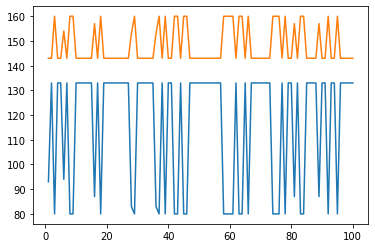

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 0  
     4| 0  | 0  
     5| 0  | 0  
     6| 0  | 0  
     7| 0  | 0  
     8| 0  | 0  
     9| 0  | 0  
    10| 0  | 1  
scores|133 |143 
 util |133 |143 

p2 has won !


In [51]:
fit_test(theta2 = numpy.array([[-1]+[1]*(env.num_of_games-1),[0]*(env.num_of_games-1)+[1]]).T)

A problem with this method is that here, $\nabla_{\theta}J(\theta)$ has either all its coefficient positive or negative.

Against another opponent ? (e.g. cooperating in the first five turns)

In [ ]:
fit_test(theta2 = numpy.array([[-1]+[0]*(env.num_of_games-1),[0]*(env.num_of_games//2)+[1]*(env.num_of_games-env.num_of_games//2)]).T)

Let's try to change our parametrization so that $\nabla_{\theta}J(\theta)$ can contain positive and negative values.

From now on, $N'_i = -1$ if every other agent have cooperated and $N'_i = \frac{N_i}{N-1}$ where $N$ is the number of players. We remind the reader that $N_i$ is the number of players who have not cooperated **among** the other players.

In [ ]:
def test(theta1 = None, theta2 = None):
    env.reset()
    action = numpy.zeros(env.num_of_players, dtype = "int") 
    N1 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])
    N2 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])

    for t in range(10):

        if t == 0:
            state = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.

        action[0] = 1*(.5 <= sigma(theta1[:t+1,0].dot(N1[:t+1]) + sum(theta1[1:t+1,1])))
        action[1] = 1*(theta2[:t+1,0].dot(N2[:t+1]) + sum(theta2[1:t+1,1]) >= 0)
        if t+1 < env.num_of_games:
            N1[t+1] = 2*action[1]-1
            N2[t+1] = 2*action[0]-1
        state, rewards, done, info = env.step(action)

        if done:
            env.close()

In [ ]:
policy1 = numpy.array([[-1]+[1]*(env.num_of_games-1),[1]*env.num_of_games]).T
policy2 = numpy.array([[-1]+[1]*(env.num_of_games-1),[1]*(env.num_of_games-1)+[2]]).T

In [ ]:
test(policy1,policy2)

In [ ]:
def fit(theta2 = None, nb_iter = 100, alpha = 1, decreasing = True):
    numpy.random.seed(42)

    scores = numpy.zeros((env.num_of_players,nb_iter))
    action = numpy.zeros(env.num_of_players, dtype = "int")

    theta1 = numpy.random.uniform(-2,2,size = 2*env.num_of_games).reshape(env.num_of_games,2)

    for i_episode in range(nb_iter):

        env.reset()
        N1 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])
        N2 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])
        R = 0

        for t in range(10):              

            # Learning agent
            action[0] = 1*(numpy.random.uniform() < sigma(theta1[:t+1,0].dot(N1[:t+1]) + sum(theta1[1:t+1,1]))) # So we can use what is done in course 7
            action[1] = 1*(theta2[:t+1,0].dot(N2[:t+1]) + sum(theta2[1:t+1,1]) >= 0)

            if t+1 < env.num_of_games:
                N1[t+1],N2[t+1] = 2*action[1]-1,2*action[0]-1

            state, reward, done, info = env.step(action)

            # Learning phase
            R += reward[0]-env.num_of_players*env.collective_reward # If we do not substract that, then R is always positive and this method would not be able to converge
            prev_norm = numpy.sqrt(numpy.sum(theta1**2))
            theta1 += alpha/numpy.sqrt(1+i_episode*decreasing) * R * (1-sigma(theta1[:t+1,0].dot(N1[:t+1])))*numpy.concatenate([N1,[0]+[1]*t+[0]*(env.num_of_games-1-t)]).reshape(2,env.num_of_games).T
            new_norm = numpy.sqrt(numpy.sum(theta1**2))
            theta1 *= prev_norm/new_norm

            if done:
                current_scores = [player.balance for player in env.player]
                for i,player in enumerate(env.player):
                    scores[i,i_episode] = player.utility(current_scores[i], current_scores)
                break
    return theta1, scores

In [ ]:
def fit_test(theta2 = None, nb_iter = 100, alpha = 1, decreasing = True, res = False):
    theta1, scores = fit(theta2, nb_iter, alpha, decreasing)
    
    plt.plot(list(range(1,nb_iter + 1)), scores[0,:])
    plt.plot(list(range(1,nb_iter + 1)), scores[1,:])
    plt.show()
    
    test(theta1 = theta1, theta2 = theta2)
    if res:
        return theta1

In [ ]:
fit_test(policy1)

In [ ]:
fit_test(policy2)

It is not better : the gradient is still too uniform.

## 4.3 More complex gradient with tensorflow
*from https://gist.github.com/shanest/535acf4c62ee2a71da498281c2dfc4f4*

In [56]:
import tensorflow as tf      # Deep Learning library

In [57]:
class PolicyGradientAgent(object):

    def __init__(self, hparams, sess):

        # initialization
        self._s = sess

        # build the graph
        self._input = tf.placeholder(tf.float32,
                shape=[None, hparams['input_size']])

        hidden1 = tf.contrib.layers.fully_connected(
                inputs=self._input,
                num_outputs=hparams['hidden_size'],
                activation_fn=tf.nn.relu,
                weights_initializer=tf.random_normal_initializer())
        
        hidden2 = tf.contrib.layers.fully_connected(
                inputs=hidden1,
                num_outputs=hparams['hidden_size'],
                activation_fn=tf.nn.relu,
                weights_initializer=tf.random_normal_initializer())
            
        hidden3= tf.contrib.layers.fully_connected(
                inputs=hidden2,
                num_outputs=hparams['hidden_size'],
                activation_fn=tf.nn.relu,
                weights_initializer=tf.random_normal_initializer())


        logits = tf.contrib.layers.fully_connected(
                inputs=hidden3,
                num_outputs=hparams['num_actions'],
                activation_fn=None)

        # op to sample an action
        self._sample = tf.reshape(tf.multinomial(logits, 1), [])

        # get log probabilities
        log_prob = tf.log(tf.nn.softmax(logits))

        # training part of graph
        self._acts = tf.placeholder(tf.int32)
        self._advantages = tf.placeholder(tf.float32)

        # get log probs of actions from episode
        indices = tf.range(0, tf.shape(log_prob)[0]) * tf.shape(log_prob)[1] + self._acts
        act_prob = tf.gather(tf.reshape(log_prob, [-1]), indices)

        # surrogate loss
        loss = -tf.reduce_sum(tf.multiply(act_prob, self._advantages))

        # update
        optimizer = tf.train.RMSPropOptimizer(hparams['learning_rate'])
        self._train = optimizer.minimize(loss)

    def act(self, observation):
        # get one action, by sampling
        return 1*(self._s.run(self._sample, feed_dict={self._input: [observation]})>0)

    def train_step(self, obs, acts, advantages):
        batch_feed = { self._input: obs, \
                self._acts: acts, \
                self._advantages: advantages }
        self._s.run(self._train, feed_dict=batch_feed)


def policy_rollout(env, agent):
    """Run one episode."""

    env.reset()
    betrayal = False
    action = numpy.zeros(2)
    
    obs = []
    acts = []
    rews = []
    state = numpy.zeros((env.num_of_games,2))
    
    for t in range(env.num_of_games):
        action[0] = agent.act(state.ravel())
        action[1] = 1*betrayal
        
        observation, reward, done, _ = env.step(action)
        
        state[t,:] = 2*action[0]-1, 2*action[1]-1
        if action[0] == 1:
            betrayal = True
        
        obs.append(state.ravel().copy())
        acts.append(action[0])
        rews.append(reward[0])
    return obs, acts, rews


def process_rewards(rews):
    """Rewards -> Advantages for one episode. """

    # total reward: length of episode
    return numpy.cumsum(rews)


def learning(verbose = False):

    # hyper parameters
    hparams = {
            'input_size': 20,
            'hidden_size': 40,
            'num_actions': 2,
            'learning_rate': 0.002
    }

    # environment params
    eparams = {
            'num_batches': 100,
            'ep_per_batch': 10
    }

    with tf.Graph().as_default(), tf.Session() as sess:

        agent = PolicyGradientAgent(hparams, sess)

        sess.run(tf.initialize_all_variables())

        for batch in range(eparams['num_batches']):

            if verbose:
                print('=====\nBATCH {}\n===='.format(batch))
            else:
                print(f"BATCH {batch}")

            b_obs, b_acts, b_rews = [], [], []

            for _ in range(eparams['ep_per_batch']):

                obs, acts, rews = policy_rollout(env, agent)
                
                if verbose:
                    print('Episode steps: {}'.format(len(obs)))

                b_obs.extend(obs)
                b_acts.extend(acts)

                advantages = process_rewards(rews)
                b_rews.extend(advantages)

            # update policy
            # normalize rewards; don't divide by 0
            b_rews = (b_rews - numpy.mean(b_rews)) / (numpy.std(b_rews) + 1e-10)

            agent.train_step(b_obs, b_acts, b_rews)
        env.close()

In [58]:
learning()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.random.categorical` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.global_variables_initializer` instead.


BATCH 0
BATCH 1
BATCH 2
BATCH 3
BATCH 4
BATCH 5
BATCH 6
BATCH 7
BATCH 8
BATCH 9
BATCH 10
BATCH 11
BATCH 12
BATCH 13
BATCH 14
BATCH 15
BATCH 16
BATCH 17
BATCH 18
BATCH 19
BATCH 20
BATCH 21
BATCH 22
BATCH 23
BATCH 24
BATCH 25
BATCH 26
BATCH 27
BATCH 28
BATCH 29
BATCH 30
BATCH 31
BATCH 32
BATCH 33
BATCH 34
BATCH 35
BATCH 36
BATCH 37
BATCH 38
BATCH 39
BATCH 40
BATCH 41
BATCH 42
BATCH 43
BATCH 44
BATCH 45
BATCH 46
BATCH 47
BATCH 48
BATCH 49
BATCH 50
BATCH 51
BATCH 52
BATCH 53
BATCH 54
BATCH 55
BATCH 56
BATCH 57
BATCH 58
BATCH 59
BATCH 60
BATCH 61
BATCH 62
BATCH 63
BATCH 64
BATCH 65
BATCH 66
BATCH 67
BATCH 68
BATCH 69
BATCH 70
BATCH 71
BATCH 72
BATCH 73
BATCH 74
BATCH 75
BATCH 76
BATCH 77
BATCH 78
BATCH 79
BATCH 80
BATCH 81
BATCH 82
BATCH 83
BATCH 84
BATCH 85
BATCH 86
BATCH 87
BATCH 88
BATCH 89
BATCH 90
BATCH 91
BATCH 92
BATCH 93
BATCH 94
BATCH 95
BATCH 96
BATCH 97
BATCH 98
BATCH 99
End of the 10 turns.
 iter | p1 | p2 
     1| 1  | 0  
     2| 1  | 1  
     3| 1  | 1  
     4| 1  | 1  
    